In [1]:
import os
import cv2
import time
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from Retinaface.get_model import get_model
from Retinaface.layers.prior_box import PriorBox
from Retinaface.utils.box_utils import decode, decode_landm
from Retinaface.utils.py_cpu_nms import py_cpu_nms
from Retinaface.config import cfg_mnet

torch.set_printoptions(sci_mode=False, linewidth=300, precision=2)
np.set_printoptions(suppress=True, linewidth=300, precision=2)

### Get Detections

Real: 5119, Fake: 22095


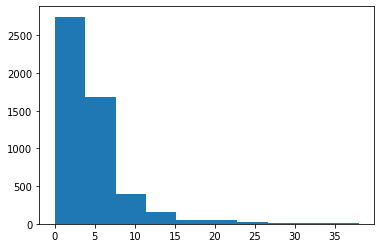

In [2]:
# Open dataframe and set filename as index
df = pd.read_pickle('master_dataframe_updated.pkl')
df.set_index('file', inplace=True)

# Get list of all numpy files with faces detected
npy = list(Path('/media/mc/2TBNVMESSD/train_bboxes/').glob('*.npy'))

# Get list of real and fake numpy files
names = [i.with_suffix('.mp4').name for i in npy]
real = []
fake = []
for name in names:
    label = df.loc[name, 'label']
    if label == 'REAL': real.append(name)
    elif label == 'FAKE': fake.append(name)
    else: print('Unknown label: {}')
print(f'Real: {len(real)}, Fake: {len(fake)}')

# Make dataframe of npy info
npy_df = pd.DataFrame(list(zip(names, npy)), columns=['file', 'npy_file'])
npy_df.set_index('file', inplace=True)
for name in names:
    npy_df.loc[name, 'label'] = df.loc[name, 'label']
    data = np.load(npy_df.loc[name, 'npy_file'], allow_pickle=True)
    npy_df.loc[name, 'num_dets'] = np.array([i.shape[0] for i in data]).mean()

# Make dataframe organizing processed files
proc_df = pd.DataFrame(list(zip(real, [[] for i in real])), columns=['real', 'fakes'])
proc_df.set_index('real', inplace=True)
for name in fake:
    original = df.loc[name, 'original']
    if original in proc_df.index:
        proc_df.loc[original, 'fakes'].append(name)

# Plot histogram of fakes per real
num = [len(proc_df.iloc[i, 0]) for i in range(len(proc_df))]
plt.hist(num);

In [22]:
# Get real videos with more than one detection
files = npy_df[(npy_df['num_dets'] > 1.0) & (npy_df['label'] == 'REAL')].index
print(len(files))

647


In [3]:
torch.set_grad_enabled(False)
model = get_model()
model.eval()
print("Finished loading model")
cudnn.benchmark = True
device = torch.device("cuda")
model = model.to(device)

Loading pretrained model from /home/mc/dev/Retinaface/Retinaface/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model


In [4]:
def get_frames(file, max_frames=None, max_dim=512):
    cap = cv2.VideoCapture(file)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is None: total_frames = num_frames
    elif max_frames > num_frames: total_frames = num_frames
    else: total_frames = max_frames
    resize = 1
    if max_dim is not None:
        max_img = max(width, height)
        if max_img > max_dim:
            resize = max_dim / max_img
    frames = []
    imgs = []
    for i in range(total_frames):
        ret, frame = cap.read()
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        if resize != 1:
            imgs.append(cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_AREA))
    return np.stack(frames).astype(np.float32), np.stack(imgs).astype(np.float32), resize

def preprocess_imgs(imgs):
    imgs -= (104, 117, 123)
    imgs = imgs.transpose(0, 3, 1, 2)
    imgs = torch.from_numpy(imgs)
    return imgs

def detect_imgs(imgs, model, cfg, resize, conf_thresh=0.5, nms_threshold=0.4):
    scale = torch.Tensor([imgs.shape[3], imgs.shape[2], imgs.shape[3], imgs.shape[2]])
    imgs = imgs.to(device)
    scale = scale.to(device)
    all_loc, all_conf, all_landms = model(imgs)

    priorbox = PriorBox(cfg, image_size=(imgs.shape[2:4]))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data

    all_dets = []
    for loc, conf, landms in zip(all_loc, all_conf, all_landms):

        boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
        boxes = boxes * scale / resize
        boxes = boxes.cpu().numpy()
        scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
        landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
        scale1 = torch.Tensor([imgs.shape[3], imgs.shape[2], imgs.shape[3], imgs.shape[2],
                               imgs.shape[3], imgs.shape[2], imgs.shape[3], imgs.shape[2],
                               imgs.shape[3], imgs.shape[2]])
        scale1 = scale1.to(device)
        landms = landms * scale1 / resize
        landms = landms.cpu().numpy()

        # Ignore low scores
        inds = np.where(scores > conf_thresh)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # Keep top-K before NMS
        order = scores.argsort()[::-1]
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]

        # NMS
        dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
        keep = py_cpu_nms(dets, nms_threshold)
        dets = dets[keep, :]
        landms = landms[keep]
        dets = np.concatenate((dets, landms), axis=1)

        all_dets.append(dets)

    return all_dets

def annotate_img(img, dets):
    ann_img = img.copy()
    for det in dets:
        # bbox
        cv2.rectangle(ann_img, (det[0], det[1]), (det[2], det[3]), (0, 0, 255), 5)
        # landms
        cv2.circle(ann_img, (det[5], det[6]), 5, (255, 255, 0), 5)
        cv2.circle(ann_img, (det[7], det[8]), 5, (0, 255, 255), 5)
        cv2.circle(ann_img, (det[9], det[10]), 5, (255, 0, 255), 5)
        cv2.circle(ann_img, (det[11], det[12]), 5, (0, 255, 0), 5)
        cv2.circle(ann_img, (det[13], det[14]), 5, (255, 0, 0), 5)
    return ann_img

def annotate_imgs(imgs, dets):
    ann_imgs = []
    for img, det in zip(imgs, dets):
        ann_imgs.append(annotate_img(img, det))
    return np.stack(ann_imgs)

def imgs2mp4(imgs, out_file):
    width, height = imgs.shape[2], imgs.shape[1]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_file, fourcc, 30, (width, height))
    for img in imgs:
        out.write(img)
    out.release()

In [5]:
in_file = 'aadqbokerz.mp4'
in_path = df.loc[in_file].filepath
print(in_path)

/home/mc/dev/dfdc_train/dfdc_train_part_25/aadqbokerz.mp4


In [7]:
total_start = time.time()

start = time.time()
frames, imgs, resize = get_frames(in_path, max_frames=75, max_dim=512)
elapsed = time.time() - start
print(f'Time for getting video frames: {elapsed:.2f}s')

start = time.time()
imgs = preprocess_imgs(imgs)
elapsed = time.time() - start
print(f'Time frames preprocessing: {elapsed:.2f}s')

start = time.time()
dets = detect_imgs(imgs, model, cfg_mnet, resize, conf_thresh=0.5, nms_threshold=0.4)
elapsed = time.time() - start
print(f'Time for model inference: {elapsed:.2f}s')

total_elapsed = time.time() - total_start
print(f'Total time: {total_elapsed:.2f}s')

Time for getting video frames: 1.08s
Time frames preprocessing: 0.12s
Time for model inference: 0.41s
Total time: 1.61s


In [206]:
out_dir = '/media/mc/2TBNVMESSD/retinaface_dets/'
for in_path in df.filepath.to_numpy()[:10]:
    out_path = str(Path(out_dir) / Path(in_path).stem) + '.npy'
    if os.path.exists(out_path): continue
    frames, imgs, resize = get_frames(in_path, max_frames=75, max_dim=512)
    imgs = preprocess_imgs(imgs)
    dets = detect_imgs(imgs, model, cfg_mnet, resize, conf_thresh=0.5, nms_threshold=0.4)
    np.save(out_path, dets, allow_pickle=True)

In [8]:
dets = np.load('/media/mc/2TBNVMESSD/retinaface_dets/aadqbokerz.npy')

In [9]:
ann_clip = annotate_imgs(frames, dets)

In [10]:
imgs2mp4(ann_clip.astype(np.uint8), '/home/mc/Desktop/test.mp4')

In [207]:
det = np.load(out_path)